# Scoring Forecast models
This notebook explains how the `Scorer` class can be used to compute the following metrics: 
* MAE (mean absolute error); 
* MSE (mean squared error); 
* CRPS (Continuous Ranked Probability Score);
* Log Score.
* Interval Score
* Weighted interval score (wis)

The CRPS and Log score assume a normal or log normal distribution based  on the `dist` parameter of the `Scorer` class. 

To see the plots below as interactive charts use `alt.renderers.enable("default")`

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("API_KEY")

In [3]:
import altair as alt 
alt.renderers.enable("png")

RendererRegistry.enable('png')

In [4]:
import numpy as np
import pandas as pd
from mosqlient import get_infodengue
from mosqlient.scoring import Scorer

To show the use of the class to compare the score of new predictions with the predictions registered on the platform it will be used the baseline model.

In [5]:
from datetime import date
from mosqlient.datastore import Infodengue
from mosqlient.forecast import Arima

It will compare the predictions of id 77 and 78, which refer to the geocode 3304557, between `2022-01-02` and `2023-06-25`. 

So initially, we will get the data that will be used to train the model and generate the new predictions:

In [6]:
disease = 'dengue'
geocode = 3304557 
end_date = date.today().strftime('%Y-%m-%d')

df = get_infodengue(api_key=api_key,
                    disease = 'dengue',
                    start_date = '2010-01-01', 
                    end_date = '2023-12-31', 
                    geocode = 3304557)

df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])

df.set_index('data_iniSE', inplace = True )
    
df = df[['casos']].rename(columns = {'casos':'y'})

df = df.resample('W-SUN').sum()

df.head()

100%|██████████| 2/2 [00:01<00:00,  1.40requests/s]


,y
data_iniSE,
2010-01-03,30
2010-01-10,44
2010-01-17,46
2010-01-24,47
2010-01-31,68


Create the model:

In [7]:
m_arima = Arima(df = df)

m_arima

Train the model: 

In [8]:
model = m_arima.train(train_ini_date='2010-01-01', train_end_date = '2021-12-31')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-292.056, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-263.166, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-297.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-289.846, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-265.069, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-302.929, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-302.144, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-309.026, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-301.338, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-307.027, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-305.684, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-306.429, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-310.932, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-303.191, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]          

Generate the out-of-sample predictions:

In [9]:
df_out = m_arima.predict_out_of_sample(horizon = 4, end_date = '2023-06-25', plot = False)

df_out.head()

,lower_95,upper_95,lower_90,upper_90,lower_80,upper_80,lower_50,upper_50,pred,date,data
0,2.380139,5.611545,2.541979,5.220186,2.744053,4.806421,3.123129,4.194438,3.614656,2022-01-02,21.0
1,2.039726,5.982188,2.213047,5.457467,2.433659,4.915432,2.859454,4.139018,3.433223,2022-01-09,14.0
2,1.717640,6.491386,1.897144,5.785913,2.130668,5.076982,2.596288,4.099103,3.252119,2022-01-16,22.0
3,1.490893,7.007506,1.671502,6.119117,1.910814,5.247764,2.401295,4.084725,3.118685,2022-01-23,19.0
0,36.296237,129.720476,39.933858,116.222755,44.643726,102.575459,53.968004,83.592784,66.974456,2022-01-30,31.0


To compare the model with other predictions in the platform, it is necessary to provide the ids of the predictions, the dataframe of the new prediction with the columns `date`, `pred`, `lower` and `upper`, and the dataframe with the `true` values to be compared (df_true). This dataframe must contain the columns `date` and `casos`.

Redefine the data to compare the predictions:

In [10]:
data = df.reset_index()

data = data.rename(columns = {'data_iniSE': 'date', 'y':'casos'})

data.head()

,date,casos
0,2010-01-03,30.0
1,2010-01-10,44.0
2,2010-01-17,46.0
3,2010-01-24,47.0
4,2010-01-31,68.0


In [11]:
%%time
score = Scorer(api_key=api_key, df_true = data, ids = [77,78], pred = df_out, conf_level=0.90)

CPU times: user 1.5 s, sys: 18 ms, total: 1.52 s
Wall time: 7.7 s


**The class above can be initialized with just the `ids` or `pred` parameter filled.** 

To see the MAE error for your model (key = `pred`) and the other use: 

In [12]:
score.mae

{'pred': 87.5411118482776, '77': 150.21846153846153, '78': 260.9831835557859}

To plot a bar chart: 

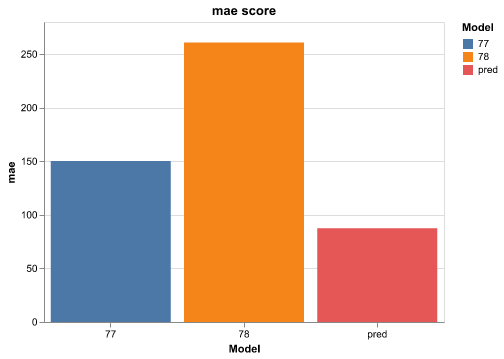

In [13]:
score.plot_mae()

To see the MSE error for your model (key = `pred`) and the other use: 

In [14]:
score.mse

{'pred': 22470.08187753273, '77': 69988.36318717948, '78': 166280.6349972801}

To plot a bar chart: 

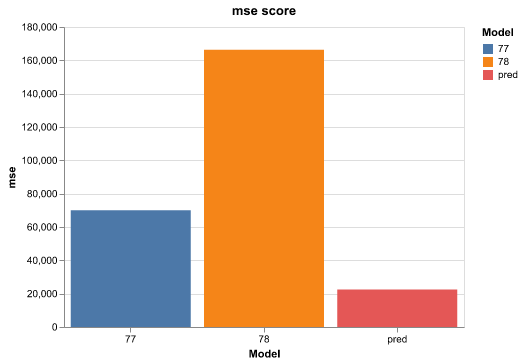

In [15]:
score.plot_mse()

To see the CRPS score for your model (key = `pred`) and the other, use the code below. The first dict contains the score by each point, and the second one shows the mean of the score.  

The CRPS score is computed using the formula below when `dist='normal'`: 
$$
\operatorname{CRPS}(\mathcal{N}(\mu_i, \sigma^2_i), y_i) = \sigma_i \left\{ \omega_i[\Phi(\omega_i) - 1] + 2\phi(\omega_i) - \frac{1}{\sqrt{\pi}}\right\},
$$

where $\Phi(\omega_i)$ and $\phi(\omega_i)$ is the cumulative distribution function (CDF) and the probability density function (PDF) of the standard normal distribution, respectively, evaluated at the normalized prediction error $\omega_i = \cfrac{y_i - \mu_i}{\sigma_i}$. Additionally, $y_i$ represents the cases observed in week $i$, $i$ is the mean forecasted value in week $i$ and $\sigma_i$ is the standard deviation of the forecast on week $i$.

When `dist='log_normal'`, then: 
$$
\operatorname{CRPS}(\operatorname{LN}(\mu_i, \sigma_i), y_i)  = y_i \left[ 2\Phi(y_i) - 1 \right] - 2\exp\left(\mu_i + \frac{\sigma_i^2}{2}\right) \left[ \Phi(\omega_i - \sigma_i) + \Phi\left(\frac{\sigma_i} {\sqrt{2}}\right) \right], 
$$ 
where $\omega_i = \frac{\operatorname{log}y_i - \mu_i}{\sigma_i}$, in which $y_i$ refers to the cases observed in week $i$, $\mu_i$ is the forecast for week $i$ and $\sigma_i$ is the standard deviation of the forecast in week $i$.

To access the CRPS score use:

In [16]:
score.crps

({'pred': date
  2022-01-02     16.828703
  2022-01-09      9.863567
  2022-01-16     17.865767
  2022-01-23     14.834895
  2022-01-30     26.642136
                   ...    
  2023-05-28    198.673466
  2023-06-04    255.756196
  2023-06-11    310.517338
  2023-06-18    288.407270
  2023-06-25    159.791379
  Length: 78, dtype: float64,
  '77': date
  2022-01-02     59.233196
  2022-01-09     38.986684
  2022-01-16     21.405121
  2022-01-23     32.657234
  2022-01-30     29.733498
                   ...    
  2023-05-28    124.618194
  2023-06-04    785.306756
  2023-06-11    644.852909
  2023-06-18    135.927228
  2023-06-25    210.630137
  Length: 78, dtype: float64,
  '78': date
  2022-01-02     68.258454
  2022-01-09     18.995392
  2022-01-16     16.776269
  2022-01-23     19.144069
  2022-01-30     23.434506
                   ...    
  2023-05-28    344.604149
  2023-06-04    180.930855
  2023-06-11    439.732579
  2023-06-18    291.643315
  2023-06-25    387.835227
  Length

To plot the score you can use: 

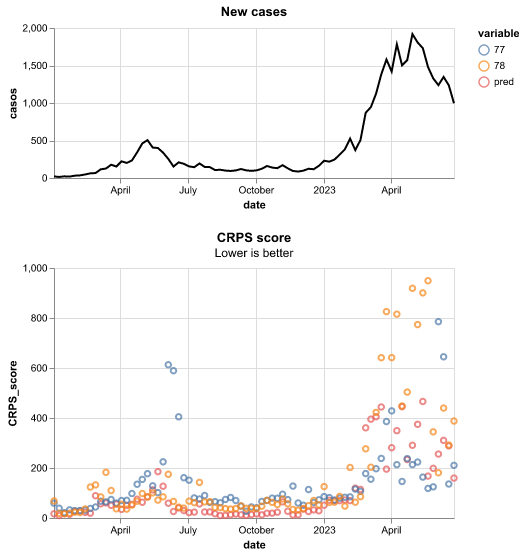

In [17]:
score.plot_crps()

To see the Log score for your model (key = `pred`) and the other, use the code below. The first dict contains the score by each point, and the second one shows the mean of the score. 

The Log score is computed using the formula below when `dist='normal'`: 
$$
\operatorname{LogS}(\mathcal{N}(\mu_i, \sigma^2_i), y_i) = log\left( \cfrac{\phi(\omega_i)}{\sigma_i}\right).
$$

When `dist='log_normal'`, then:
$$
\operatorname{LogS}(\operatorname{LN}(\mu_i, \sigma_i), y_i) = \log y_i + \log \sigma_i + \frac{1}{2} \log (2\pi) \\ + \frac{(\log y_i - \mu_i)^2}{2\sigma_i^2}. \nonumber   
$$

To access the score use:

In [18]:
score.log_score

({'pred': date
  2022-01-02   -33.468594
  2022-01-09   -14.732222
  2022-01-16   -17.856424
  2022-01-23   -12.694800
  2022-01-30    -5.901760
                  ...    
  2023-05-28    -7.628395
  2023-06-04    -7.784895
  2023-06-11    -8.036783
  2023-06-18    -7.841786
  2023-06-25    -7.407098
  Length: 78, dtype: float64,
  '77': date
  2022-01-02    -4.810859
  2022-01-09    -4.492307
  2022-01-16    -4.687486
  2022-01-23    -4.678048
  2022-01-30    -5.127454
                  ...    
  2023-05-28    -7.096612
  2023-06-04   -10.497586
  2023-06-11    -8.829387
  2023-06-18    -7.279166
  2023-06-25    -7.598320
  Length: 78, dtype: float64,
  '78': date
  2022-01-02   -5.133771
  2022-01-09   -4.223787
  2022-01-16   -4.478269
  2022-01-23   -4.389041
  2022-01-30   -4.862467
                  ...   
  2023-05-28   -8.048407
  2023-06-04   -7.365099
  2023-06-11   -8.456563
  2023-06-18   -7.881526
  2023-06-25   -8.447551
  Length: 78, dtype: float64},
 {'pred': -6.94452054

To plot this score: 

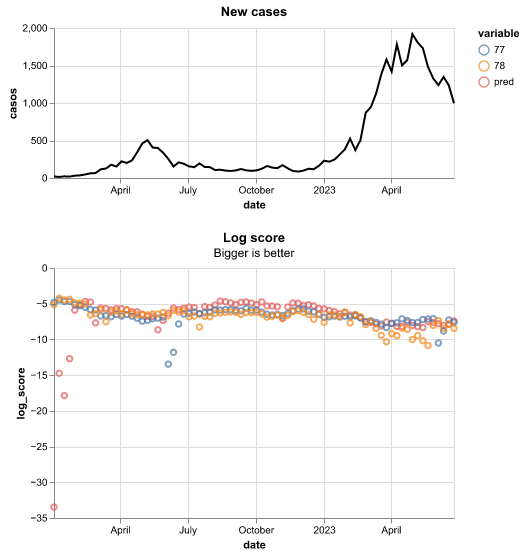

In [19]:
score.plot_log_score()

To see the Interval score for your model (key = `pred`) and the other, use the code below. The first dict contains the score by each point, and the second one shows the mean of the score. 

The Interval score is computed using the formula below: 

$$
S^{int}_\alpha(l_i, u_i; y_i) = u_i - l_i + \cfrac{2}{\alpha}(l_i - y_i)I\{y_i < l_i\} + \cfrac{2}{\alpha}(y_i - u_i)I\{y_i > u_i\}
$$

where $I$ is the indicator function, $\alpha$ the significance level of the interval, $u_i$ the upper value of the interval at week $i$ and $l_i$ the lower value. 

To access the score use:

In [20]:
score.interval_score

({'pred': date
  2022-01-02      369.160417
  2022-01-09      235.739064
  2022-01-16      402.057125
  2022-01-23      346.569959
  2022-01-30      178.677158
                    ...     
  2023-05-28    15984.737132
  2023-06-04    16142.778577
  2023-06-11    19718.044529
  2023-06-18    16975.380193
  2023-06-25    13622.133304
  Length: 78, dtype: float64,
  '77': date
  2022-01-02      420.000000
  2022-01-09      280.000000
  2022-01-16      440.000000
  2022-01-23      380.000000
  2022-01-30      620.000000
                    ...     
  2023-05-28    19698.103291
  2023-06-04     1630.342126
  2023-06-11     4703.602460
  2023-06-18    24720.000000
  2023-06-25    19920.000000
  Length: 78, dtype: float64,
  '78': date
  2022-01-02      420.000000
  2022-01-09      280.000000
  2022-01-16      440.000000
  2022-01-23      380.000000
  2022-01-30      620.000000
                    ...     
  2023-05-28    25722.341880
  2023-06-04    21305.987251
  2023-06-11    25830.663561


To visualise a plot with the score use:

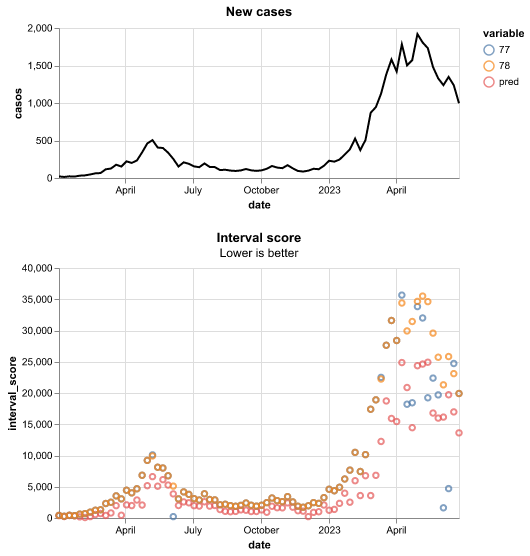

In [21]:
score.plot_interval_score()

The weighted interval score (WIS) is compute using the equation below:
$$
\text{WIS}(F, y) = \frac{1}{K + 1/2} \left( w_0|y - m| + \sum_{k=1}^K [w_K S^{int}_{\alpha_k} (l_K, u_K; y) ]\right), 
$$

by default, \( w_k = \frac{\alpha_k}{2} \) and \( w_0 = \frac{1}{2} \). In this equation, \( K \) denotes the number of intervals, and \( l_k \) and \( u_k \) represent the lower and upper bounds of the \( k \)-th confidence interval, respectively. The implementation defines the \( \alpha_k \) values based on the names of the prediction columns.


In [22]:
score.wis

({'pred': date
  2022-01-02     16.344187
  2022-01-09      9.248474
  2022-01-16     17.089928
  2022-01-23     13.910310
  2022-01-30     19.595216
                   ...    
  2023-05-28    166.933824
  2023-06-04    223.211784
  2023-06-11    277.237919
  2023-06-18    168.646095
  2023-06-25    113.664638
  Length: 78, dtype: float64,
  '77': date
  2022-01-02     71.070818
  2022-01-09     55.549032
  2022-01-16     24.091173
  2022-01-23     42.120557
  2022-01-30     35.575138
                   ...    
  2023-05-28    117.375011
  2023-06-04    451.074264
  2023-06-11    372.338675
  2023-06-18    129.720985
  2023-06-25    177.310819
  Length: 78, dtype: float64,
  '78': date
  2022-01-02     53.585231
  2022-01-09     21.423796
  2022-01-16     20.870103
  2022-01-23     21.425641
  2022-01-30     30.595116
                   ...    
  2023-05-28    240.319440
  2023-06-04    156.229845
  2023-06-11    263.707593
  2023-06-18    221.456064
  2023-06-25    222.104994
  Length

To visualise a plot with the score use:

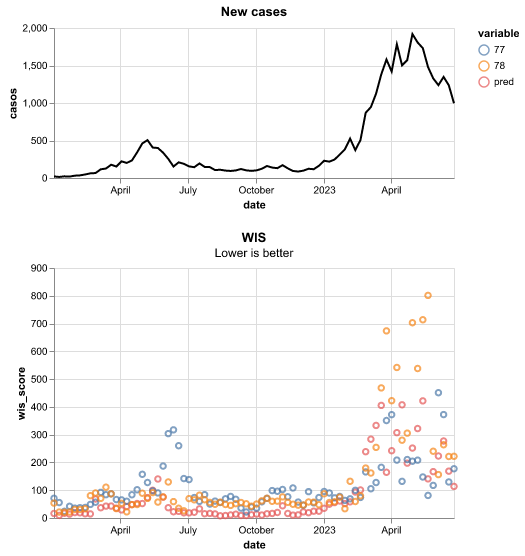

In [23]:
score.plot_wis()

To generate a table with a summary of the scores, you can use the following: 

In [24]:
score.summary

,mae,mse,crps,log_score,interval_score,wis
id,,,,,,
pred,87.541112,22470.081878,105.831493,-6.944521,5465.129071,85.575434
77,150.218462,69988.363187,140.382590,-6.775674,7806.481043,114.424606
78,260.983184,166280.634997,178.828111,-6.912100,9088.950060,137.189106


To generate a plot of the predictions, you can use the following: 

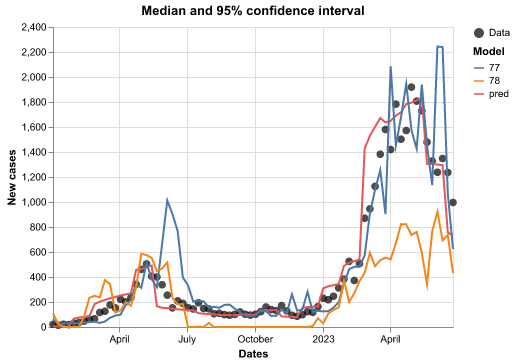

In [25]:
score.plot_predictions()

The class will select the bigger range of dates that contains information about each prediction dataframe. If you want to see the model's performance in a lower range, use the method below. The new range of dates provided must be between `score.min_date` and `score.max_date`. Otherwise, it will return an error.

In [26]:
score.set_date_range(start_date = '2023-01-01', end_date='2023-06-01' )

In this case:

In [27]:
score.summary

,mae,mse,crps,log_score,interval_score,wis
id,,,,,,
pred,170.319455,56309.195185,238.380937,-7.300045,12155.663207,199.492379
77,204.412273,76788.430632,169.617454,-7.272044,18261.449915,147.977551
78,588.199306,506643.235469,427.249268,-8.301220,20813.301409,312.039665


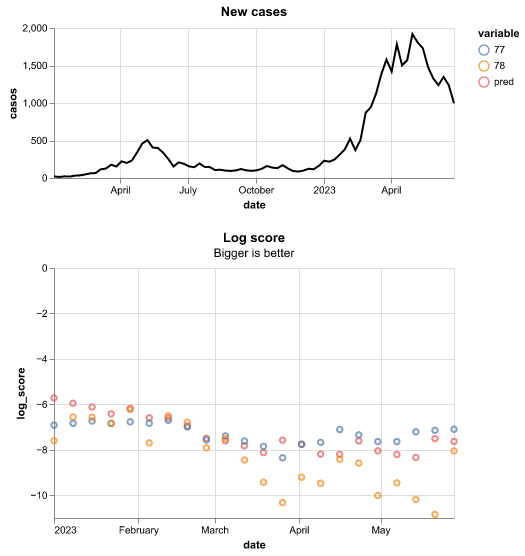

In [28]:
score.plot_log_score()

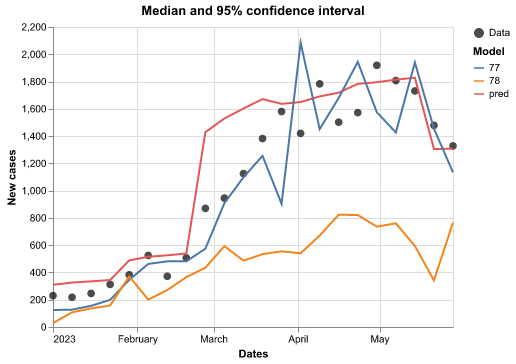

In [29]:
score.plot_predictions()